# Statistical Forecasting

# 1 Import Data

In [269]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import norm
import matplotlib.pyplot as plt

In [270]:
# Import dataset to dataframe
def import_data():
    data = pd.read_csv('dataset.csv')
    return data

data = import_data()
display(data)
print('There are a total of', data['Product'].nunique(),
     'unique products in the dataset')

,Year,Month,Product,Demand
0,2007,1,Product 1,2884
1,2007,1,Product 2,2521
2,2007,1,Product 3,1029
3,2007,1,Product 4,870
4,2007,1,Product 5,693
...,...,...,...,...
4372,2017,1,Product 34,3
4373,2017,1,Product 46,2
4374,2017,1,Product 48,1
4375,2017,1,Product 36,1


There are a total of 66 unique products in the dataset


In [271]:
# To filter the product
product = 'Product 36'
dataset = data[data['Product'] == product]
display(dataset)

,Year,Month,Product,Demand
35,2007,1,Product 36,1
71,2007,2,Product 36,5
150,2007,4,Product 36,1
187,2007,5,Product 36,2
220,2007,6,Product 36,8
...,...,...,...,...
4236,2016,9,Product 36,4
4271,2016,10,Product 36,2
4304,2016,11,Product 36,2
4341,2016,12,Product 36,1


# 2 Forecast KPI Function

In [272]:
# Forecast KPI Function
def kpi(df):
    dem_ave = df.loc[df['Error'].notnull(),'Demand'].mean()
    
    # Bias
    bias_abs = df['Error'].mean()
    bias_rel = bias_abs / dem_ave
    print('Bias: {:0.2f}, {:.2%}'.format(bias_abs,bias_rel))
    
    #MAPE
    MAPE = (df['Error'].abs()/df['Demand']).mean()
    print('MAPE: {:.2%}'.format(MAPE))
    
    #MAE
    MAE_abs = df['Error'].abs().mean()
    MAE_rel = MAE_abs / dem_ave
    print('MAE: {:0.2f}, {:.2%}'.format(MAE_abs, MAE_rel))
    
    #RMSE
    RMSE_abs = np.sqrt((df['Error']**2).mean())
    RMSE_rel = RMSE_abs / dem_ave
    print('RMSE: {:0.2f}, {:.2%}'.format(RMSE_abs, RMSE_rel))

# 3 Moving Average

Moving Average Forecast - Product 36


,Demand,Forecast,Error
Period,,,
0,1.0,NaN,NaN
1,5.0,NaN,NaN
2,1.0,NaN,NaN
3,2.0,2.333333,-0.333333
4,8.0,2.666667,5.333333
...,...,...,...
111,NaN,1.333333,NaN
112,NaN,1.333333,NaN
113,NaN,1.333333,NaN


Moving Average KPI - Product 36
Bias: -0.02, -0.37%
MAPE: 77.79%
MAE: 2.91, 49.79%
RMSE: 4.00, 68.44%


array([<AxesSubplot:xlabel='Period'>, <AxesSubplot:xlabel='Period'>,
       <AxesSubplot:xlabel='Period'>], dtype=object)

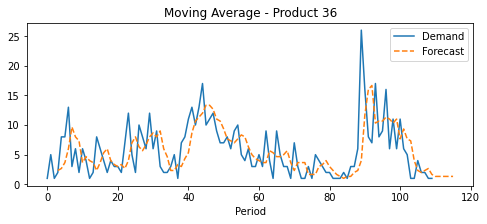

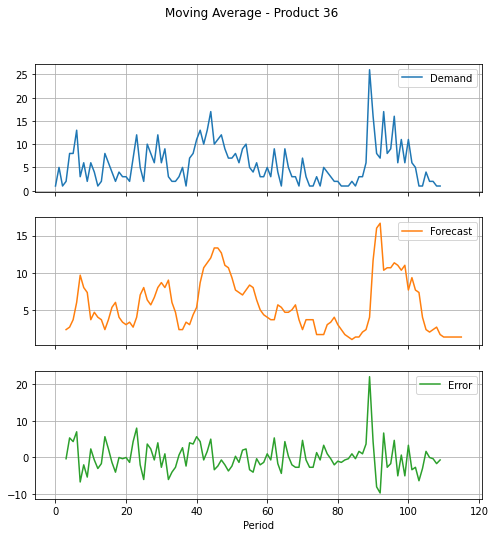

In [273]:
# Moving Average Function
def moving_average(d, extra_periods=1, n=3):
    cols = len(d) # Historical period length
    d = np.append(d, [np.nan]*extra_periods) # Append np.nan into the demand array to cover future periods
    f = np.full(cols + extra_periods, np.nan) # Define the forecast array
    
    # Create all the t+1 forecast until end of historical period
    for t in range(n, cols): 
        f[t] = np.mean(d[t-n:t])
    
    # Forecast for all extra periods
    f[t+1:] = np.mean(d[t-n+1:t+1]) 
    df = pd.DataFrame.from_dict({'Demand':d, 'Forecast':f, 'Error':d-f}) # Return a Dataframe with the demand, forecast and error
    return df

# Forecast
print(f'Moving Average Forecast - {product}')
d = dataset['Demand'].tolist() # Convert dataframe column to a list
df = moving_average(d, extra_periods=6, n=3) # Call our new function
df.index.name = 'Period'
display(df)

# KPI
print(f'Moving Average KPI - {product}')
kpi(df) # Compute the accuracy KPIs
# Plot
df[['Demand', 'Forecast']].plot(figsize=(8,3), title=f'Moving Average - {product}',style=['-', '--'])
df.plot(figsize=(8,8), title=f'Moving Average - {product}', subplots=True, grid=True)

# 3.1. Moving Average Optimization

Best solution found: Moving Average, n: 3. RMSE: 4.0


,Demand,Forecast,Error
Period,,,
0,1.0,NaN,NaN
1,5.0,NaN,NaN
2,1.0,NaN,NaN
3,2.0,2.333333,-0.333333
4,8.0,2.666667,5.333333
...,...,...,...
111,NaN,1.333333,NaN
112,NaN,1.333333,NaN
113,NaN,1.333333,NaN


Moving Average - Optimization KPI: RMSE - Best Solution KPI - Product 36
Bias: -0.02, -0.37%
MAPE: 77.79%
MAE: 2.91, 49.79%
RMSE: 4.00, 68.44%


array([<AxesSubplot:xlabel='Period'>, <AxesSubplot:xlabel='Period'>,
       <AxesSubplot:xlabel='Period'>], dtype=object)

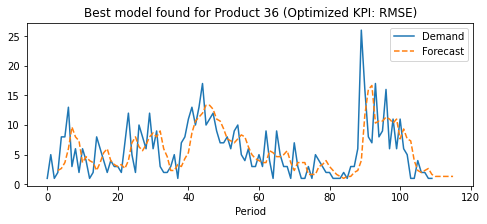

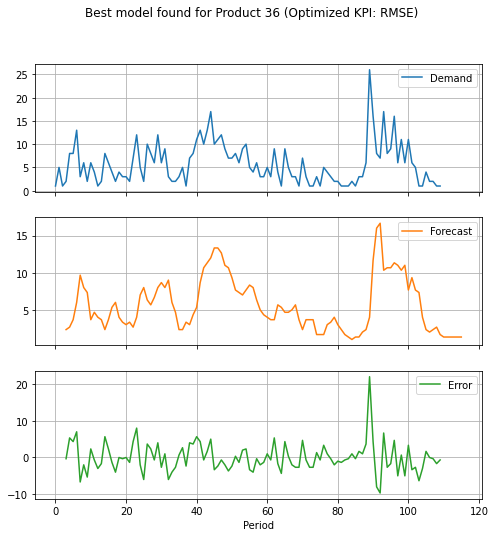

In [274]:
# Objetive KPI: RMSE
def moving_average_opti(d, extra_periods=6):
    params = []
    dfs = []
    KPIs = []

    lst = list(np.arange(1,12))
    for n in lst:
        df = moving_average(d, extra_periods=extra_periods, n=n)
        params.append(f'Moving Average, n: {n}')
        dfs.append(df)
        RMSE = np.sqrt((df['Error']**2).mean())
        KPIs.append(RMSE)
    mini = np.argmin(KPIs)

    print(f'Best solution found: {params[mini]}. RMSE:', round(KPIs[mini], 2))
    return dfs[mini]

# Forecast
d = dataset['Demand'].tolist() # Convert dataframe column to a list
df = moving_average_opti(d, extra_periods=6)
df.index.name = 'Period'
display(df)

# KPI
print(f'Moving Average - Optimization KPI: RMSE - Best Solution KPI - {product}')
kpi(df)

# Plot
# Subplot per component
df[['Demand', 'Forecast']].plot(figsize=(8,3), title=f'Best model found for {product} (Optimized KPI: RMSE)', style=['-','--'])
df.plot(figsize=(8,8), title=f'Best model found for {product} (Optimized KPI: RMSE)', subplots=True, grid=True)

Best solution found: Moving Average, n: 4. MAE: 2.89


,Demand,Forecast,Error
Period,,,
0,1.0,NaN,NaN
1,5.0,NaN,NaN
2,1.0,NaN,NaN
3,2.0,NaN,NaN
4,8.0,2.25,5.75
...,...,...,...
111,NaN,1.50,NaN
112,NaN,1.50,NaN
113,NaN,1.50,NaN


Moving Average - Optimization KPI: MAE - Best Solution KPI - Product 36
Bias: -0.02, -0.36%
MAPE: 79.09%
MAE: 2.89, 49.08%
RMSE: 4.01, 68.07%


array([<AxesSubplot:xlabel='Period'>, <AxesSubplot:xlabel='Period'>,
       <AxesSubplot:xlabel='Period'>], dtype=object)

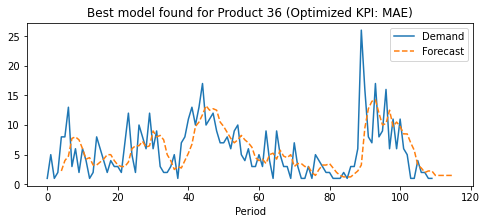

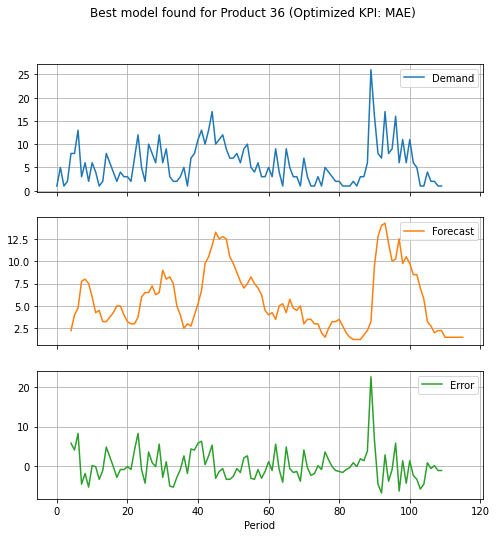

In [275]:
# Objetive KPI: MAE
def moving_average_opti(d, extra_periods=6):
    params = []
    dfs = []
    KPIs = []

    lst = list(np.arange(1,12))
    for n in lst:
        df = moving_average(d, extra_periods=extra_periods, n=n)
        params.append(f'Moving Average, n: {n}')
        dfs.append(df)
        MAE = df['Error'].abs().mean()
        KPIs.append(MAE)
    mini = np.argmin(KPIs)

    print(f'Best solution found: {params[mini]}. MAE:', round(KPIs[mini], 2))
    return dfs[mini]

# Forecast
d = dataset['Demand'].tolist() # Convert dataframe column to a list
df = moving_average_opti(d, extra_periods=6)
df.index.name = 'Period'
display(df)

# KPI
print(f'Moving Average - Optimization KPI: MAE - Best Solution KPI - {product}')
kpi(df)

# Plot
# Subplot per component
df[['Demand', 'Forecast']].plot(figsize=(8,3), title=f'Best model found for {product} (Optimized KPI: MAE)', style=['-','--'])
df.plot(figsize=(8,8), title=f'Best model found for {product} (Optimized KPI: MAE)', subplots=True, grid=True)

# 4 Simple Exponential Smooting
Forecast = Level

Simple Exponential Smoothing Forecast - Product 36


,Demand,Forecast,Error
Period,,,
0,1.0,NaN,NaN
1,5.0,1.000000,4.000
2,1.0,2.600000,-1.600
3,2.0,1.960000,0.040
4,8.0,1.976000,6.024
...,...,...,...
111,NaN,1.550522,NaN
112,NaN,1.550522,NaN
113,NaN,1.550522,NaN


Simple Exponential Smoothing KPI - Product 36
Bias: 0.01, 0.22%
MAPE: 78.40%
MAE: 2.87, 49.53%
RMSE: 3.90, 67.23%


array([<AxesSubplot:xlabel='Period'>, <AxesSubplot:xlabel='Period'>,
       <AxesSubplot:xlabel='Period'>], dtype=object)

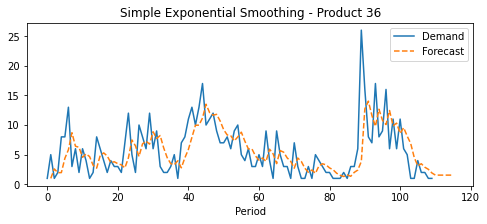

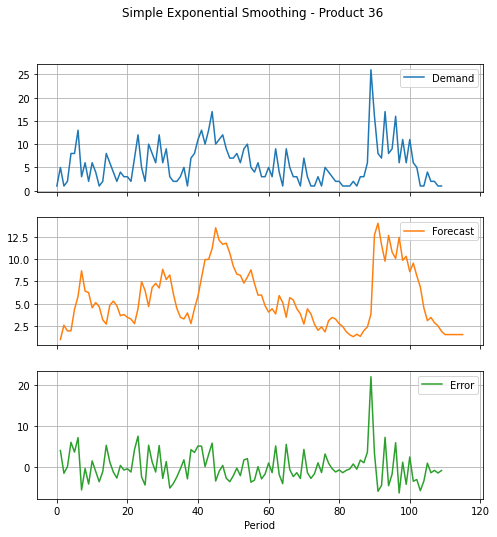

In [279]:
# The level is the average value around which the demand varies over time.
# Simple Exponential Smoothing Function
def simple_exp_smooth(d, extra_periods=1, alpha=0.4):
    cols = len(d) # Historical period lenth
    d = np.append(d, [np.nan]*extra_periods) # Append np.nan into the demand array to cover future periods
    f = np.full(cols + extra_periods, np.nan) # Forecast array

    # Initialization of first forecast
    f[1] = d[0]
    
    # Create all the t+1 forecast until end of historical period
    for t in range(2, cols + 1): 
        f[t] = alpha * d[t-1] + (1-alpha)*f[t-1]
    
    # Forecast for all extra periods
    for t in range(cols+1, cols + extra_periods):
        f[t] = f[t-1] #Update the forecast as the previous forecast
        
    df = pd.DataFrame.from_dict({'Demand':d, 'Forecast':f, 'Error':d-f})
    return df

# Forecast
print(f'Simple Exponential Smoothing Forecast - {product}')
d = dataset['Demand'].tolist() # Convert dataframe column to list
df = simple_exp_smooth(d, extra_periods=6, alpha=0.4)
df.index.name = 'Period'
display(df)

# KPI
print(f'Simple Exponential Smoothing KPI - {product}')
kpi(df)

# Plot
df[['Demand', 'Forecast']].plot(figsize=(8,3), title=f'Simple Exponential Smoothing - {product}', style=['-','--'])
df.plot(figsize=(8,8), title=f'Simple Exponential Smoothing - {product}', subplots=True, grid=True)

# 5 Double Exponential Smoothing
Forecast = Level + Trend

Double Exponential Smoothing Forecast - Product 36


,Demand,Forecast,Level,Trend,Error
Period,,,,,
0,1.0,NaN,1.000000,4.000000,NaN
1,5.0,5.000000,5.000000,4.000000,0.0000
2,1.0,9.000000,5.800000,2.720000,-8.0000
3,2.0,8.520000,5.912000,1.676800,-6.5200
4,8.0,7.588800,7.753280,1.742592,0.4112
...,...,...,...,...,...
111,NaN,-0.023482,-0.023482,-0.292420,NaN
112,NaN,-0.315902,-0.315902,-0.292420,NaN
113,NaN,-0.608322,-0.608322,-0.292420,NaN


Double Exponential Smoothing KPI - Product 36
Bias: -0.25, -4.24%
MAPE: 82.06%
MAE: 3.14, 54.12%
RMSE: 4.36, 75.21%


array([<AxesSubplot:xlabel='Period'>, <AxesSubplot:xlabel='Period'>,
       <AxesSubplot:xlabel='Period'>, <AxesSubplot:xlabel='Period'>,
       <AxesSubplot:xlabel='Period'>], dtype=object)

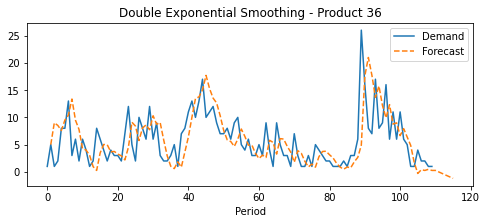

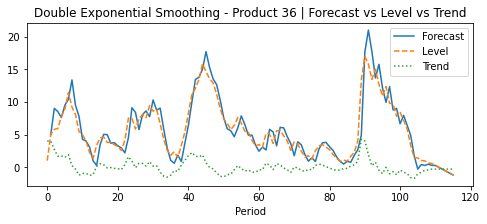

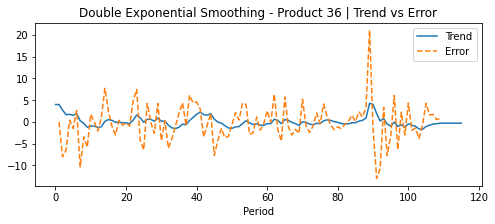

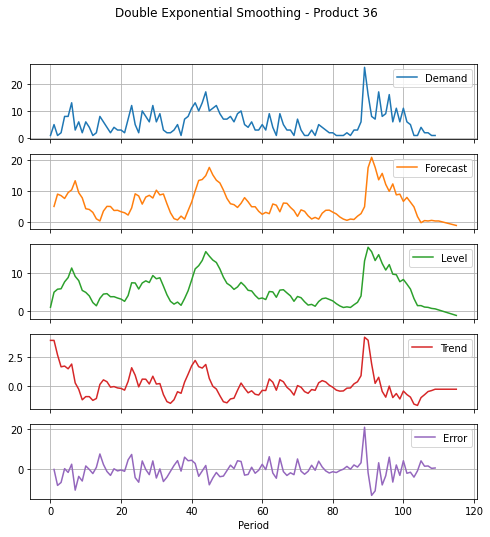

In [280]:
# Double Exponential Smoothing Function
def double_exp_smooth(d, extra_periods=1, alpha=0.4, beta=0.4):
    cols = len(d) # Historical period length
    d = np.append(d, [np.nan]*extra_periods) # Append np.nan into the demand array to cover future periods
    f, a, b = np.full((3, cols + extra_periods), np.nan) # Creation of the level, trend and forecast arrays

    # Level & Trend initialization
    a[0] = d[0]
    b[0] = d[1] - d[0]

    # Create all the t+1 forecast
    for t in range(1, cols):
        f[t] = a[t-1] + b[t-1]
        a[t] = alpha*d[t] + (1-alpha)*(a[t-1] + b[t-1])
        b[t] = beta*(a[t] - a[t-1]) + (1-beta)*b[t-1]

    # Forecast for all extra periods
    for t in range(cols, cols + extra_periods): 
        f[t] = a[t-1] + b[t-1]
        a[t] = f[t]
        b[t] = b[t-1]
        
    df = pd.DataFrame.from_dict({'Demand':d, 'Forecast':f, 'Level':a, 'Trend':b, 'Error':d-f})
    return df

# Forecast
print(f'Double Exponential Smoothing Forecast - {product}')
d = dataset['Demand'].tolist() # Convert dataframe column to a list
df = double_exp_smooth(d, extra_periods=6, alpha=0.4,
                         beta=0.4)
df.index.name = 'Period'
display(df)

# KPI
print(f'Double Exponential Smoothing KPI - {product}')
kpi(df)

# Plot
df[['Demand', 'Forecast']].plot(figsize=(8,3), title=f'Double Exponential Smoothing - {product}', style=['-','--'])
df[['Forecast', 'Level','Trend']].plot(figsize=(8,3), title=f'Double Exponential Smoothing - {product} | Forecast vs Level vs Trend', style=['-','--',':'])
df[['Trend', 'Error']].plot(figsize=(8,3), title=f'Double Exponential Smoothing - {product} | Trend vs Error', style=['-','--'])
df.plot(figsize=(8,8), title=f'Double Exponential Smoothing - {product}', subplots=True, grid=True)


# 6 Double Exponential Smoothing with Damped Trend
Forecast = Level + Trend*phi

Double Exponential Smoothing with Damped Trend Forecast - Product 36


,Demand,Forecast,Level,Trend,Error
Period,,,,,
0,1.0,NaN,1.000000,4.000000,NaN
1,5.0,4.600000,4.760000,3.664000,0.400000
2,1.0,8.057600,5.234560,2.168384,-7.057600
3,2.0,7.186106,5.111663,1.121769,-5.186106
4,8.0,6.121255,6.872753,1.310191,1.878745
...,...,...,...,...,...
111,NaN,0.407938,0.407938,-0.203730,NaN
112,NaN,0.224581,0.224581,-0.183357,NaN
113,NaN,0.059559,0.059559,-0.165022,NaN


Double Exponential Smoothing with Damped Trend KPI - Product 36
Bias: -0.19, -3.30%
MAPE: 78.76%
MAE: 2.99, 51.60%
RMSE: 4.15, 71.57%


array([<AxesSubplot:xlabel='Period'>, <AxesSubplot:xlabel='Period'>,
       <AxesSubplot:xlabel='Period'>, <AxesSubplot:xlabel='Period'>,
       <AxesSubplot:xlabel='Period'>], dtype=object)

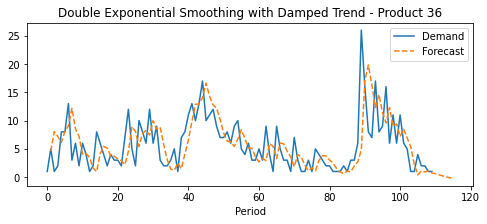

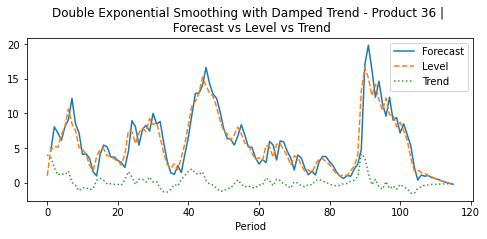

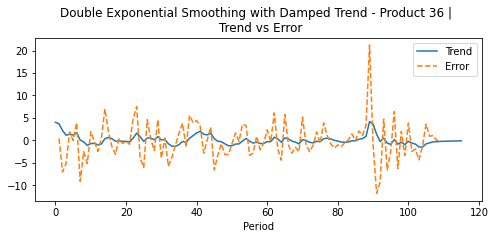

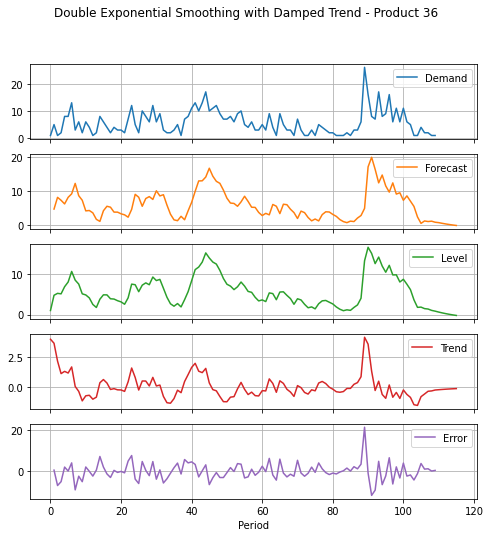

In [281]:
# Double Exponential Smoothing with Damped Trend Function
def double_exp_smooth_damped(d, extra_periods=1, alpha=0.4, beta=0.4, phi=0.9):
    
    cols = len(d) # Historical period length
    d = np.append(d, [np.nan]*extra_periods) # Append np.nan into the demand array to cover future periods

    # Creation of the level, trend, and forecast arrays
    f, a, b = np.full((3, cols+extra_periods), np.nan)

    # Level & Trend initialization
    a[0] = d[0]
    b[0] = d[1] - d[0]

    # Create all the t+1 forecast
    for t in range(1, cols):
        f[t] = a[t-1] + phi*b[t-1]
        a[t] = alpha*d[t] + (1-alpha)*(a[t-1] + phi*b[t-1])
        b[t] = beta*(a[t]-a[t-1]) + (1-beta)*phi*b[t-1]
    
    # Forecast for all extra periods
    for t in range(cols, cols + extra_periods):
        f[t] = a[t-1] + phi*b[t-1]
        a[t] = f[t]
        b[t] = phi*b[t-1]

    df = pd.DataFrame.from_dict({'Demand':d, 'Forecast':f, 'Level':a, 'Trend':b, 'Error':d-f})
    return df

# Forecast
print(f'Double Exponential Smoothing with Damped Trend Forecast - {product}')
d = dataset['Demand'].tolist() # Convert dataframe column to a list
df = double_exp_smooth_damped(d, extra_periods=6, alpha=0.4,
                             beta=0.4, phi=0.9)
df.index.name = 'Period'
display(df)

# KPI
print(f'Double Exponential Smoothing with Damped Trend KPI - {product}')
kpi(df)

# Plot
df[['Demand', 'Forecast']].plot(figsize=(8,3), title=f'Double Exponential Smoothing with Damped Trend - {product}', style=['-','--'])
df[['Forecast', 'Level','Trend']].plot(figsize=(8,3), title=f'Double Exponential Smoothing with Damped Trend - {product} | \n Forecast vs Level vs Trend', style=['-','--',':'])
df[['Trend', 'Error']].plot(figsize=(8,3), title=f'Double Exponential Smoothing with Damped Trend - {product} | \n Trend vs Error', style=['-','--'])
df.plot(figsize=(8,8), title=f'Double Exponential Smoothing with Damped Trend - {product}', subplots=True, grid=True)

# 7 Triple Exponential Smoothing
Forecast = (Level + Trend*phi)*Season

Triple Exponential Smoothing Forecast - Product 36


,Demand,Forecast,Level,Trend,Season,Error
Period,,,,,,
0,1.0,NaN,1.259058,8.726574,0.794245,NaN
1,5.0,4.563043,9.462038,7.993542,0.500719,0.436957
2,1.0,18.853090,10.347125,4.670548,1.131894,-17.853090
3,2.0,12.840833,9.636893,2.238003,0.882494,-10.840833
4,8.0,12.964288,9.866519,1.300372,1.112710,-4.964288
...,...,...,...,...,...,...
111,NaN,1.366271,1.563804,-0.042621,0.873684,NaN
112,NaN,1.756558,1.525445,-0.038359,1.151506,NaN
113,NaN,2.447906,1.490921,-0.034523,1.641875,NaN


Triple Exponential Smoothing KPI - Product 36
Bias: -0.54, -9.30%
MAPE: 81.88%
MAE: 3.06, 52.72%
RMSE: 4.47, 77.15%


array([<AxesSubplot:xlabel='Period'>, <AxesSubplot:xlabel='Period'>,
       <AxesSubplot:xlabel='Period'>, <AxesSubplot:xlabel='Period'>,
       <AxesSubplot:xlabel='Period'>, <AxesSubplot:xlabel='Period'>],
      dtype=object)

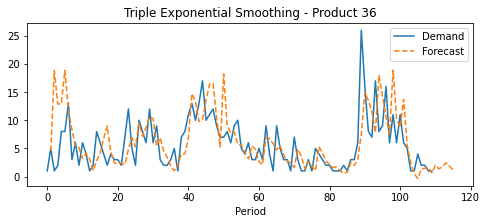

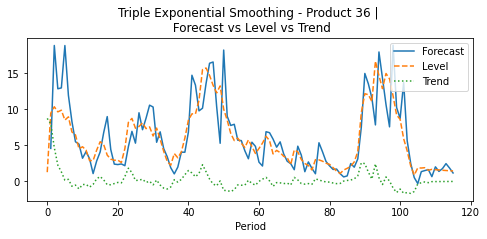

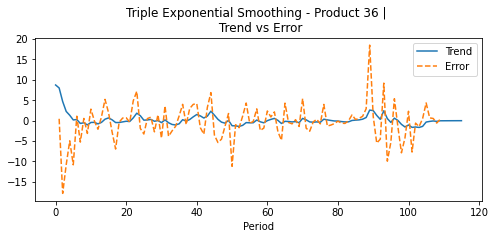

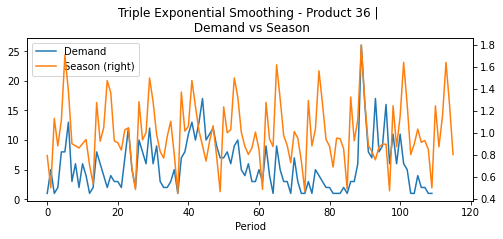

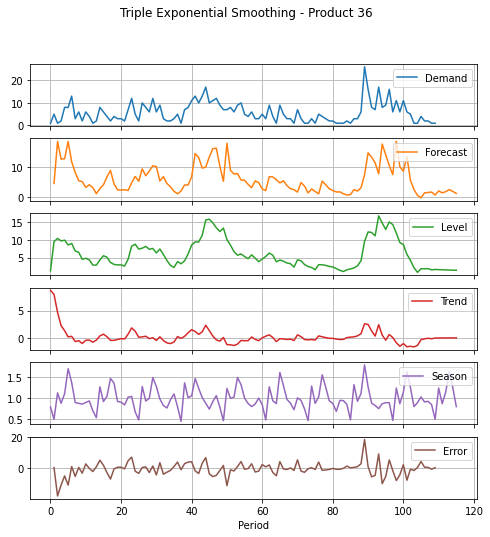

In [282]:
# Multiplicative Seasonal Factors Function
def seasonal_factors_mul(s, d, slen, cols):
    for i in range(slen):
        s[i] = np.mean(d[i:cols:slen]) # Seasonal average. array[start:stop:step-size]
    s /= np.mean(s[:slen]) # Scale all season factors. Scale all reason factors (sum of factors = slen)
    return s

# Tripple Exponential Smoothing Function
def triple_exp_smooth_mul(d, slen=12, extra_periods=1, alpha=0.4, beta=0.4, phi=0.9, gamma=0.3):
    
    cols = len(d) # Historical period length
    d = np.append(d, [np.nan]*extra_periods) # Append np.nan into the demand array to cover future periods
    
    # Components initialization
    f, a, b, s = np.full((4, cols+extra_periods), np.nan)
    s = seasonal_factors_mul(s, d, slen, cols)
    
    # Level & Trend initialization
    a[0] = d[0]/s[0]
    b[0] = d[1]/s[1] - d[0]/s[0]
    
    # Create the forecast for the first season
    for t in range(1, slen):
        f[t] = (a[t-1] + phi*b[t-1])*s[t]
        a[t] = alpha*d[t]/s[t] + (1-alpha)*(a[t-1] + phi*b[t-1])
        b[t] = beta*(a[t]-a[t-1]) + (1-beta)*phi*b[t-1]
        
    # Create all the t+1 forecast
    for t in range(slen, cols):
        f[t] = (a[t-1] + phi*b[t-1])*s[t-slen]
        a[t] = alpha*d[t]/s[t-slen] + (1-alpha)*(a[t-1] + phi*b[t-1])
        b[t] = beta*(a[t]-a[t-1]) + (1-beta)*phi*b[t-1]
        s[t] = gamma*d[t]/a[t] + (1-gamma)*s[t-slen]
        
    # Forecast for extra periods
    for t in range (cols, cols+extra_periods):
        f[t] = (a[t-1] + phi*b[t-1])*s[t-slen]
        a[t] = f[t]/s[t-slen]
        b[t] = phi*b[t-1]
        s[t] = s[t-slen]
        
    df = pd.DataFrame.from_dict({'Demand':d, 'Forecast':f, 'Level':a, 'Trend':b, 'Season':s, 'Error':d-f})
    return df

# Forecast
print(f'Triple Exponential Smoothing Forecast - {product}')
d = dataset['Demand'].tolist() # Convert dataframe column to a list
df = triple_exp_smooth_mul(d, slen=12, extra_periods=6, alpha=0.4,
                             beta=0.4, phi=0.9, gamma=0.2)
df.index.name = 'Period'
display(df)

# KPI
print(f'Triple Exponential Smoothing KPI - {product}')
kpi(df)

# Plot
# Subplot per component
df[['Demand', 'Forecast']].plot(figsize=(8,3), title=f'Triple Exponential Smoothing - {product}', style=['-','--'])
df[['Forecast', 'Level', 'Trend']].plot(figsize=(8,3), secondary_y=['Season'], title=f'Triple Exponential Smoothing - {product} | \n Forecast vs Level vs Trend', style=['-','--',':'])
df[['Trend', 'Error']].plot(figsize=(8,3), title=f'Triple Exponential Smoothing - {product} | \n Trend vs Error', style=['-','--'])
df[['Demand', 'Season']].plot(figsize=(8,3), secondary_y=['Season'], title=f'Triple Exponential Smoothing - {product} | \n Demand vs Season')
df.plot(figsize=(8,8), title=f'Triple Exponential Smoothing - {product}', subplots=True, grid=True)

# 8 Triple Additive Exponential Smoothing
Forecast = Level + Trend*phi + Season

- This new additive model is best suited for items with stable or low demand.
- The two seasonal models (additive and multiplicative) are complementary and should allow you to forecast any seasonal product.

Triple Additive Exponential Smooting Forecast - Product 36


,Demand,Forecast,Level,Trend,Season,Error
Period,,,,,,
0,1.0,NaN,2.191667,5.700000,-1.191667,NaN
1,5.0,4.430000,7.549667,5.221200,-2.891667,0.570000
2,1.0,13.012636,7.443692,2.777058,0.763889,-12.012636
3,2.0,9.262489,7.038049,1.337354,-0.680556,-7.262489
4,8.0,8.894446,7.883890,1.060507,0.652778,-0.894446
...,...,...,...,...,...,...
111,NaN,2.339519,3.255166,0.228823,-0.915647,NaN
112,NaN,4.172876,3.461107,0.205941,0.711769,NaN
113,NaN,8.136705,3.646453,0.185346,4.490252,NaN


Triple Additive Exponential Smooting KPI - Product 36
Bias: -0.24, -4.14%
MAPE: 80.83%
MAE: 2.88, 49.68%
RMSE: 3.92, 67.61%


array([<AxesSubplot:xlabel='Period'>, <AxesSubplot:xlabel='Period'>,
       <AxesSubplot:xlabel='Period'>, <AxesSubplot:xlabel='Period'>,
       <AxesSubplot:xlabel='Period'>, <AxesSubplot:xlabel='Period'>],
      dtype=object)

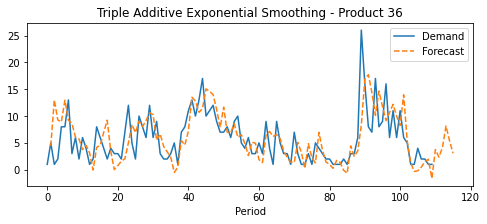

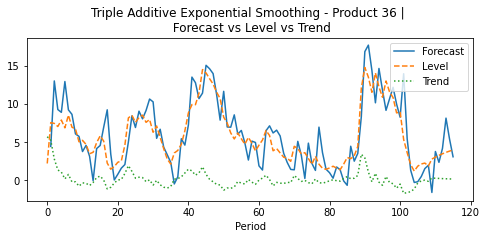

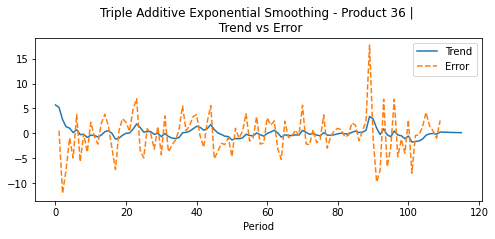

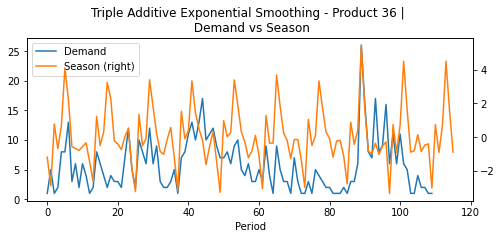

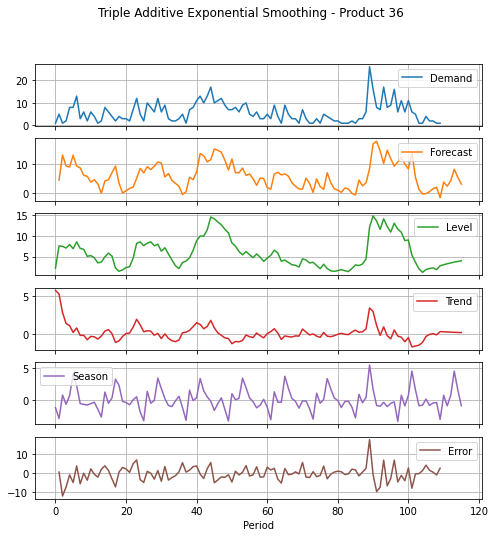

In [283]:
# Additive Seasonal Factors Function
def seasonal_factors_add(s, d, slen, cols):
    for i in range(slen):
        s[i] = np.mean(d[i:cols:slen]) # Calculate seasons average
    s -= np.mean(s[:slen]) # Scale all season factors (sum of factors = 0)
    return s

# Triple Additive Smoothing Function
def triple_exp_smooth_add(d, slen=12, extra_periods=1, alpha=0.4, beta=0.4, phi=0.9, gamma=0.3):
    cols = len(d) # Historical period length
    d = np.append(d, [np.nan]*extra_periods) # Append np.nan into the demand array to cover future periods

    # Components initialization
    f, a, b, s = np.full((4, cols+extra_periods), np.nan)
    s = seasonal_factors_add(s, d, slen, cols)

    # Level & Trend initialization
    a[0] = d[0] - s[0]
    b[0] = (d[1] - s[1]) - (d[0] - s[0])

    # Create the forecast for the first season
    for t in range(1, slen):
        f[t] = a[t-1] + phi*b[t-1] + s[t]
        a[t] = alpha*(d[t]-s[t]) + (1-alpha)*(a[t-1]+phi*b[t-1])
        b[t] = beta*(a[t]-a[t-1]) + (1-beta)*phi*b[t-1]

    # Forecast for all the t+1 forecast
    for t in range(slen, cols):
        f[t] = a[t-1] + phi*b[t-1] + s[t-slen]
        a[t] = alpha*(d[t] - s[t-slen]) + (1-alpha)*(a[t-1]+phi*b[t-1])
        b[t] = beta*(a[t] - a[t-1]) + (1-beta)*phi*b[t-1]
        s[t] = gamma*(d[t] - a[t]) + (1-gamma)*s[t-slen]

    # Forecast for all extra periods
    for t in range(cols, cols+extra_periods):
        f[t] = a[t-1] + phi*b[t-1] + s[t-slen]
        a[t] = f[t] - s[t-slen]
        b[t] = phi*b[t-1]
        s[t] = s[t-slen]

    df = pd.DataFrame.from_dict({'Demand':d, 'Forecast':f, 'Level':a, 'Trend':b, 'Season':s, 'Error':d-f})
    return df

# Forecast
print(f'Triple Additive Exponential Smooting Forecast - {product}')
d = dataset['Demand'].tolist() # Convert dataframe column to a list
df = triple_exp_smooth_add(d, slen=12, extra_periods=6, alpha=0.4,
                             beta=0.4, phi=0.9, gamma=0.2)
df.index.name = 'Period'
display(df)

# KPI
print(f'Triple Additive Exponential Smooting KPI - {product}')
kpi(df)

# Plot
# Subplot per component
df[['Demand', 'Forecast']].plot(figsize=(8,3), title=f'Triple Additive Exponential Smoothing - {product}', style=['-','--'])
df[['Forecast', 'Level', 'Trend']].plot(figsize=(8,3), secondary_y=['Season'], title=f'Triple Additive Exponential Smoothing - {product} | \n Forecast vs Level vs Trend', style=['-','--',':'])
df[['Trend', 'Error']].plot(figsize=(8,3), title=f'Triple Additive Exponential Smoothing - {product} | \n Trend vs Error', style=['-','--'])
df[['Demand', 'Season']].plot(figsize=(8,3), secondary_y=['Season'], title=f'Triple Additive Exponential Smoothing - {product} | \n Demand vs Season')
df.plot(figsize=(8,8), title=f'Triple Additive Exponential Smoothing - {product}', subplots=True, grid=True)

# 9 Optimization KPI: RMSE

Best solution found: Triple Additive Exponential Smoothing, alpha: 0.4, beta: 0.2, gamma: 0.05. RMSE: 3.57


,Demand,Forecast,Level,Trend,Season,Error
Period,,,,,,
0,1.0,NaN,2.191667,5.700000,-1.191667,NaN
1,5.0,3.290000,6.865667,4.126800,-2.891667,1.710000
2,1.0,10.518316,5.947100,2.127295,0.763889,-9.518316
3,2.0,6.755651,5.533946,1.108654,-0.680556,-4.755651
4,8.0,6.962782,6.724891,0.859035,0.652778,1.037218
...,...,...,...,...,...,...
111,NaN,2.293794,3.012173,0.031973,-0.718379,NaN
112,NaN,3.580985,3.034554,0.022381,0.546431,NaN
113,NaN,7.188039,3.050220,0.015667,4.137819,NaN


Optimization KPI: RMSE - Best Solution KPI - Product 36
Bias: -0.19, -3.35%
MAPE: 73.03%
MAE: 2.62, 45.15%
RMSE: 3.57, 61.57%


array([<AxesSubplot:xlabel='Period'>, <AxesSubplot:xlabel='Period'>,
       <AxesSubplot:xlabel='Period'>, <AxesSubplot:xlabel='Period'>,
       <AxesSubplot:xlabel='Period'>, <AxesSubplot:xlabel='Period'>],
      dtype=object)

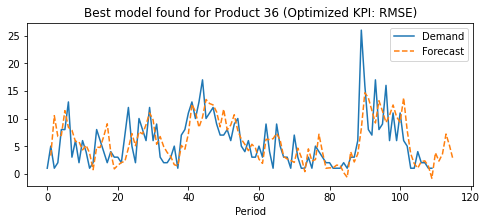

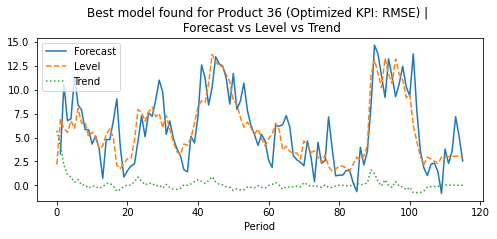

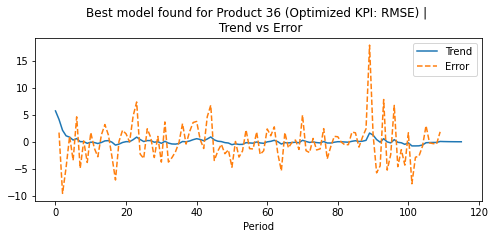

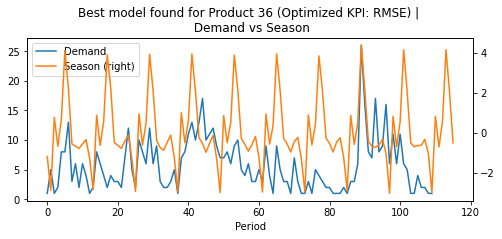

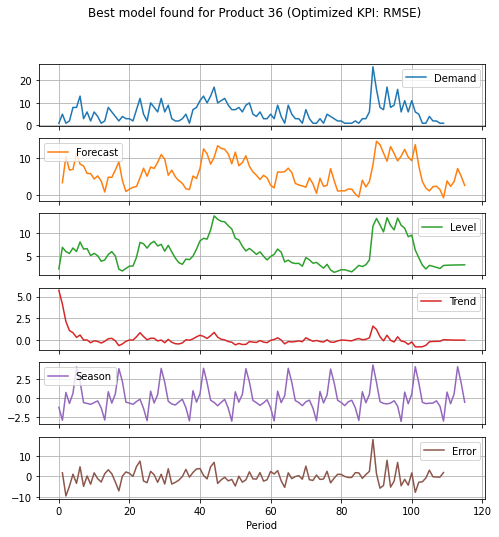

In [284]:
# Objetive KPI: RMSE
def exp_smooth_opti_rmse(d, extra_periods=6, slen=12):
    params = [] # contains all the different parameter sets
    dfs = [] # contains all the DataFrames returned by the different models
    KPIs = [] # contains the results of each model

    for alpha in [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]:
        df = simple_exp_smooth(d, extra_periods=extra_periods, alpha=alpha)
        params.append(f'Simple Exponential Smoothing, alpha: {alpha}')
        dfs.append(df)
        RMSE = np.sqrt((df['Error']**2).mean())
        KPIs.append(RMSE)

        for beta in [0.05, 0.1, 0.2, 0.3, 0.4]:
            df = double_exp_smooth(d, extra_periods=extra_periods, alpha=alpha, beta=beta)
            params.append(f'Double Exponential Smoothing, alpha: {alpha}, beta: {beta}')
            dfs.append(df)
            RMSE = np.sqrt((df['Error']**2).mean())
            KPIs.append(RMSE)
            
            for phi in [0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.00]: # To forget the trend over time
                df = double_exp_smooth_damped(d, extra_periods=extra_periods, alpha=alpha, beta=beta, phi=phi)
                params.append(f'Double Exponential Smoothing with Damped Trend, alpha: {alpha}, beta: {beta}, phi: {phi}')
                dfs.append(df)
                RMSE = np.sqrt((df['Error']**2).mean())
                KPIs.append(RMSE)

                for gamma in [0.05, 0.1, 0.2, 0.3]:
                    df = triple_exp_smooth_mul(d, slen=slen, extra_periods=extra_periods, alpha=alpha, beta=beta, phi=phi, gamma=gamma)
                    params.append(f'Triple Multiplicative Exponential Smoothing, alpha: {alpha}, beta: {beta}, phi: {phi}, gamma: {gamma}')
                    dfs.append(df)
                    RMSE = np.sqrt((df['Error']**2).mean())
                    KPIs.append(RMSE)

                    df = triple_exp_smooth_add(d, slen=slen, extra_periods=extra_periods, alpha=alpha, beta=beta, phi=phi, gamma=gamma)
                    params.append(f'Triple Additive Exponential Smoothing, alpha: {alpha}, beta: {beta}, gamma: {gamma}')
                    dfs.append(df)
                    RMSE = np.sqrt((df['Error']**2).mean())
                    KPIs.append(RMSE)
        
                mini = np.argmin(KPIs)
        # np.argmin() returns the location of the minimum value in an array.
        # Remember that, in Python, the index (location) of the first element in an array is 0.
    print(f'Best solution found: {params[mini]}. RMSE:', round(KPIs[mini], 2))
    return dfs[mini]

# Forecast
d = dataset['Demand'].tolist() # Convert dataframe column to a list
df = exp_smooth_opti_rmse(d, extra_periods=6, slen=12)
df.index.name = 'Period'
display(df)

# KPI
print(f'Optimization KPI: RMSE - Best Solution KPI - {product}')
kpi(df)

# Plot
# Subplot per component
df[['Demand', 'Forecast']].plot(figsize=(8,3), title=f'Best model found for {product} (Optimized KPI: RMSE)', style=['-','--'])
df[['Forecast', 'Level', 'Trend']].plot(figsize=(8,3), secondary_y=['Season'], title=f'Best model found for {product} (Optimized KPI: RMSE) | \n Forecast vs Level vs Trend', style=['-','--',':'])
df[['Trend', 'Error']].plot(figsize=(8,3), title=f'Best model found for {product} (Optimized KPI: RMSE) | \n Trend vs Error', style=['-','--'])
df[['Demand', 'Season']].plot(figsize=(8,3), secondary_y=['Season'], title=f'Best model found for {product} (Optimized KPI: RMSE) | \n Demand vs Season')
df.plot(figsize=(8,8), title=f'Best model found for {product} (Optimized KPI: RMSE)', subplots=True, grid=True)

# 10 Optimization KPI: MAE

Best solution found: Triple Additive Exponential Smoothing, alpha: 0.4, beta: 0.05, gamma: 0.05. MAE: 2.62


,Demand,Forecast,Level,Trend,Season,Error
Period,,,,,,
0,1.0,NaN,2.191667,5.700000,-1.191667,NaN
1,5.0,3.290000,6.865667,4.024200,-2.891667,1.710000
2,1.0,10.446496,5.904008,2.628010,0.763889,-9.446496
3,2.0,7.063060,5.718392,1.738346,-0.680556,-5.063060
4,8.0,7.588011,7.100029,1.225082,0.652778,0.411989
...,...,...,...,...,...,...
111,NaN,2.319314,3.038920,-0.003605,-0.719606,NaN
112,NaN,3.579379,3.036396,-0.002523,0.542983,NaN
113,NaN,7.165884,3.034630,-0.001766,4.131254,NaN


Optimization KPI: MAE - Best Solution KPI - Product 36
Bias: -0.26, -4.41%
MAPE: 75.11%
MAE: 2.62, 45.13%
RMSE: 3.58, 61.71%


array([<AxesSubplot:xlabel='Period'>, <AxesSubplot:xlabel='Period'>,
       <AxesSubplot:xlabel='Period'>, <AxesSubplot:xlabel='Period'>,
       <AxesSubplot:xlabel='Period'>, <AxesSubplot:xlabel='Period'>],
      dtype=object)

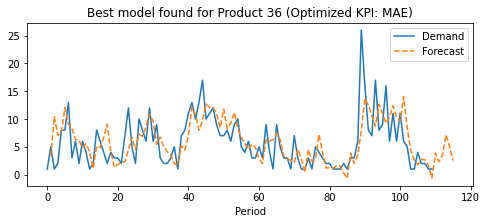

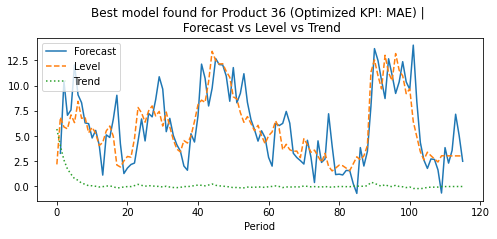

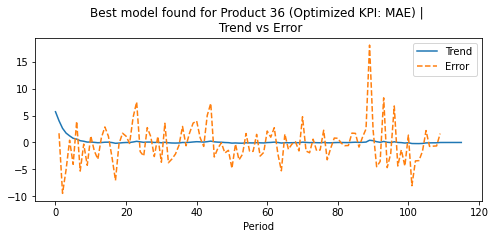

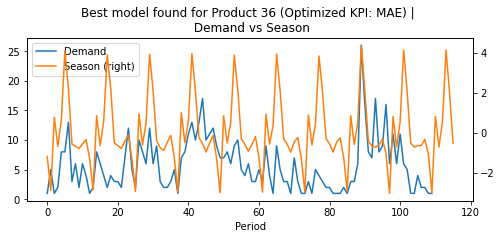

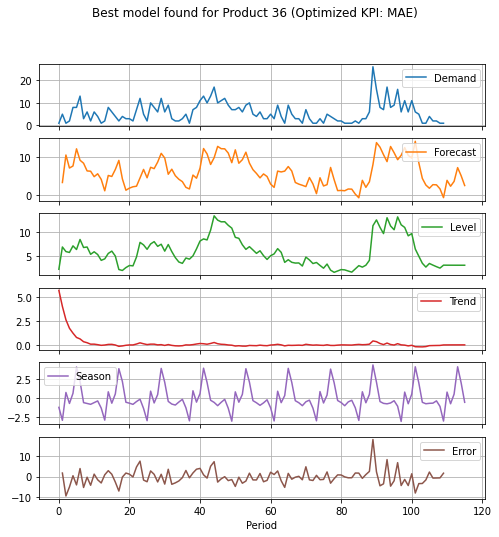

In [285]:
# Objetive KPI: MAE
def exp_smooth_opti_mae(d, extra_periods=6, slen=12):
    params = [] # contains all the different parameter sets
    dfs = [] # contains all the DataFrames returned by the different models
    KPIs = [] # contains the results of each model
    
    for alpha in [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]:
        df = simple_exp_smooth(d, extra_periods=extra_periods, alpha=alpha)
        params.append(f'Simple Exponential Smoothing, alpha: {alpha}')
        dfs.append(df)
        MAE = df['Error'].abs().mean()
        KPIs.append(MAE)
        
        for beta in [0.05, 0.1, 0.2, 0.3, 0.4]:
            df = double_exp_smooth(d, extra_periods=extra_periods, alpha=alpha, beta=beta)
            params.append(f'Double Exponential Smoothing, alpha: {alpha}, beta: {beta}')
            dfs.append(df)
            MAE = df['Error'].abs().mean()
            KPIs.append(MAE)
            
            for phi in [0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.00]: # To forget the trend over time
                df = double_exp_smooth_damped(d, extra_periods=extra_periods, alpha=alpha, beta=beta, phi=phi)
                params.append(f'Double Exponential Smoothing with Damped Trend, alpha: {alpha}, beta: {beta}, phi: {phi}')
                dfs.append(df)
                MAE = df['Error'].abs().mean()
                KPIs.append(MAE)

                for gamma in [0.05, 0.1, 0.2, 0.3]:
                    df = triple_exp_smooth_mul(d, slen=slen, extra_periods=extra_periods, alpha=alpha, beta=beta, phi=phi, gamma=gamma)
                    params.append(f'Triple Multiplicative Exponential Smoothing, alpha: {alpha}, beta: {beta}, phi: {phi}, gamma: {gamma}')
                    dfs.append(df)
                    MAE = df['Error'].abs().mean()
                    KPIs.append(MAE)

                    df = triple_exp_smooth_add(d, slen=slen, extra_periods=extra_periods, alpha=alpha, beta=beta, phi=phi, gamma=gamma)
                    params.append(f'Triple Additive Exponential Smoothing, alpha: {alpha}, beta: {beta}, gamma: {gamma}')
                    dfs.append(df)
                    MAE = df['Error'].abs().mean()
                    KPIs.append(MAE)
        
                mini = np.argmin(KPIs)
        # np.argmin() returns the location of the minimum value in an array.
        # Remember that, in Python, the index (location) of the first element in an array is 0.
    print(f'Best solution found: {params[mini]}. MAE:', round(KPIs[mini], 2))
    return dfs[mini]

# Forecast
d = dataset['Demand'].tolist() # Convert dataframe column to a list
df = exp_smooth_opti_mae(d, extra_periods=6, slen=12)
df.index.name = 'Period'
display(df)

# KPI
print(f'Optimization KPI: MAE - Best Solution KPI - {product}')
kpi(df)

# Plot
# Subplot per component
df[['Demand', 'Forecast']].plot(figsize=(8,3), title=f'Best model found for {product} (Optimized KPI: MAE)', style=['-','--'])
df[['Forecast', 'Level', 'Trend']].plot(figsize=(8,3), secondary_y=['Season'], title=f'Best model found for {product} (Optimized KPI: MAE) | \n Forecast vs Level vs Trend', style=['-','--',':'])
df[['Trend', 'Error']].plot(figsize=(8,3), title=f'Best model found for {product} (Optimized KPI: MAE) | \n Trend vs Error', style=['-','--'])
df[['Demand', 'Season']].plot(figsize=(8,3), secondary_y=['Season'], title=f'Best model found for {product} (Optimized KPI: MAE) | \n Demand vs Season')
df.plot(figsize=(8,8), title=f'Best model found for {product} (Optimized KPI: MAE)', subplots=True, grid=True)

# 11 Deal with Outliers
These high (or low) points will result in overreactions in your forecast or your safety stocks, ultimately resulting in (at best) manual corrections or (at worst) dead stocks, losses, and a nasty bullwhip effect.

These outliers pop out all the time in modern supply chains. They are mostly due to tow main reasons:
- Mistakes and Error
- Exceptional Demand

In [286]:
# Import norm to compute probabilities
from scipy.stats import norm

# Compute the error mean and error standard deviation
m = df['Error'].mean()
s = df['Error'].std()

# Get the percentage of the normal distribution function of each error with norm.cdf
prob = norm.cdf(df['Error'], m, s) # Normal cumulative distribution function

# Define probabilities ranges based on 2 standard deviation
outliers = (prob > 0.99) | (prob < 0.01)

# Re-compute the error mean and standard deviation, but this time, exclude the outliers. '~' useful for exclude.
m2 = df.loc[~outliers, 'Error'].mean()
s2 = df.loc[~outliers, 'Error'].std()

# Update the lower and upper acceptable thresholds based on these new m2 and s2 values
limit_high = norm.ppf(0.99, m2, s2) + df['Forecast'] # Percent point function
limit_low = norm.ppf(0.01, m2, s2) + df['Forecast'] # Percent point function

# Forecast with updated outliers values
df['Updated'] = df['Demand'].clip(lower=limit_low, upper=limit_high)
display(df.tail(10))

# Replace the updated values in the main dataset
updated_values = df.loc[df['Updated'].notnull(),'Updated']
dataset['Demand'] = dataset['Demand'].replace(dataset['Demand'].tolist(), updated_values)
print('Dataset with Demand updated')
display(dataset)

,Demand,Forecast,Level,Trend,Season,Error,Updated
Period,,,,,,,
106,2.0,2.730408,3.054748,-0.071719,-0.638416,-0.730408,2.0
107,2.0,2.684592,2.730708,-0.063895,-0.340490,-0.684592,2.0
108,1.0,1.642050,2.429161,-0.057568,-1.063192,-0.642050,1.0
109,1.0,-0.647027,3.047674,-0.007357,-2.986480,1.647027,1.0
110,NaN,3.853948,3.042525,-0.005150,0.811424,NaN,NaN
111,NaN,2.319314,3.038920,-0.003605,-0.719606,NaN,NaN
112,NaN,3.579379,3.036396,-0.002523,0.542983,NaN,NaN
113,NaN,7.165884,3.034630,-0.001766,4.131254,NaN,NaN
114,NaN,5.050215,3.033393,-0.001236,2.016822,NaN,NaN


Dataset with Demand updated


/var/folders/zb/60dzf9rs2g5dzbn8q93wz0hw0000gn/T/ipykernel_5298/1630672832.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Demand'] = dataset['Demand'].replace(dataset['Demand'].tolist(), updated_values)


,Year,Month,Product,Demand
35,2007,1,Product 36,1.0
71,2007,2,Product 36,5.0
150,2007,4,Product 36,1.0
187,2007,5,Product 36,2.0
220,2007,6,Product 36,8.0
...,...,...,...,...
4236,2016,9,Product 36,4.0
4271,2016,10,Product 36,2.0
4304,2016,11,Product 36,2.0
4341,2016,12,Product 36,1.0


# 12 Optimization KPI: RMSE (without Outliers)

Best solution found: Triple Additive Exponential Smoothing, alpha: 0.4, beta: 0.3, gamma: 0.05. RMSE: 3.04


,Demand,Forecast,Level,Trend,Season,Error
Period,,,,,,
0,1.0,NaN,2.163842,5.577600,-1.163842,NaN
1,5.0,3.326720,6.737474,4.105113,-2.741442,1.673280
2,1.0,10.443943,5.833476,1.740306,0.832890,-9.443943
3,2.0,6.620633,5.203437,0.663738,-0.431057,-4.620633
4,8.0,6.660578,6.203823,0.625347,0.992524,1.339422
...,...,...,...,...,...,...
111,NaN,2.490771,2.957350,0.060254,-0.466579,NaN
112,NaN,3.890675,2.999528,0.042178,0.891147,NaN
113,NaN,5.971148,3.029053,0.029525,2.942095,NaN


Optimization KPI: RMSE - Best Solution KPI (without Outliers) - Product 36
Bias: -0.16, -2.84%
MAPE: 72.24%
MAE: 2.47, 43.03%
RMSE: 3.04, 53.07%


array([<AxesSubplot:xlabel='Period'>, <AxesSubplot:xlabel='Period'>,
       <AxesSubplot:xlabel='Period'>, <AxesSubplot:xlabel='Period'>,
       <AxesSubplot:xlabel='Period'>, <AxesSubplot:xlabel='Period'>],
      dtype=object)

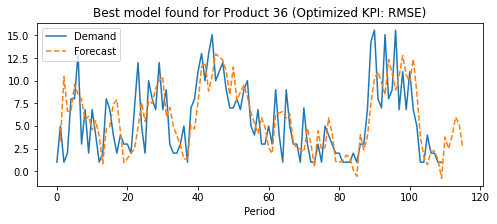

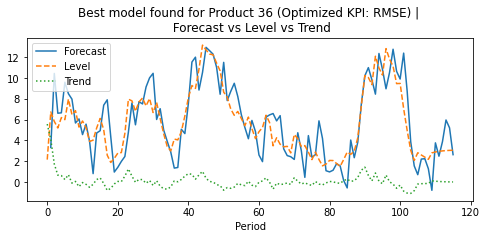

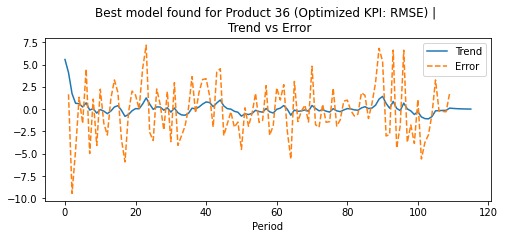

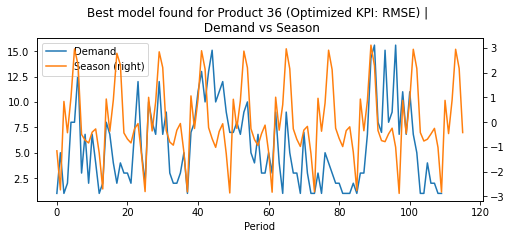

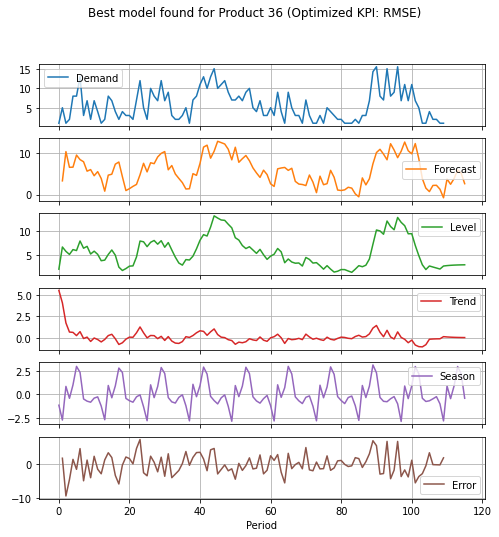

In [287]:
# Forecast
d = dataset['Demand'].tolist() # Convert dataframe column to a list
df = exp_smooth_opti_rmse(d, extra_periods=6, slen=12)
df.index.name = 'Period'
display(df)

# KPI
print(f'Optimization KPI: RMSE - Best Solution KPI (without Outliers) - {product}')
kpi(df)

# Plot
# Subplot per component
df[['Demand', 'Forecast']].plot(figsize=(8,3), title=f'Best model found for {product} (Optimized KPI: RMSE)', style=['-','--'])
df[['Forecast', 'Level', 'Trend']].plot(figsize=(8,3), secondary_y=['Season'], title=f'Best model found for {product} (Optimized KPI: RMSE) | \n Forecast vs Level vs Trend', style=['-','--',':'])
df[['Trend', 'Error']].plot(figsize=(8,3), title=f'Best model found for {product} (Optimized KPI: RMSE) | \n Trend vs Error', style=['-','--'])
df[['Demand', 'Season']].plot(figsize=(8,3), secondary_y=['Season'], title=f'Best model found for {product} (Optimized KPI: RMSE) | \n Demand vs Season')
df.plot(figsize=(8,8), title=f'Best model found for {product} (Optimized KPI: RMSE)', subplots=True, grid=True)

# 13 Optimization KPI: MAE (without Outliers)

Best solution found: Triple Additive Exponential Smoothing, alpha: 0.4, beta: 0.05, gamma: 0.05. MAE: 2.45


,Demand,Forecast,Level,Trend,Season,Error
Period,,,,,,
0,1.0,NaN,2.163842,5.577600,-1.163842,NaN
1,5.0,3.326720,6.737474,3.937785,-2.741442,1.673280
2,1.0,10.326814,5.763198,2.569914,0.832890,-9.326814
3,2.0,7.131080,5.509706,1.696318,-0.431057,-5.131080
4,8.0,7.689652,6.821267,1.193629,0.992524,0.310348
...,...,...,...,...,...,...
111,NaN,2.477290,2.944496,-0.006696,-0.467206,NaN
112,NaN,3.826147,2.939809,-0.004687,0.886339,NaN
113,NaN,5.868582,2.936528,-0.003281,2.932055,NaN


Optimization KPI: MAE - Best Solution KPI (without Outliers) - Product 36
Bias: -0.25, -4.39%
MAPE: 74.99%
MAE: 2.45, 42.82%
RMSE: 3.07, 53.56%


array([<AxesSubplot:xlabel='Period'>, <AxesSubplot:xlabel='Period'>,
       <AxesSubplot:xlabel='Period'>, <AxesSubplot:xlabel='Period'>,
       <AxesSubplot:xlabel='Period'>, <AxesSubplot:xlabel='Period'>],
      dtype=object)

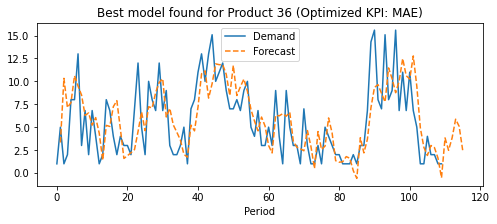

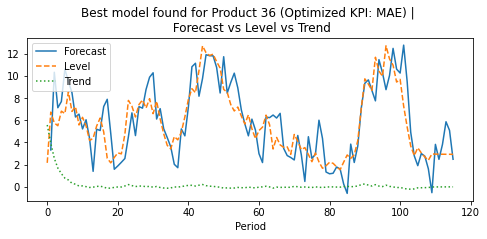

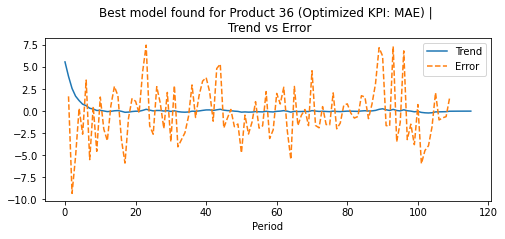

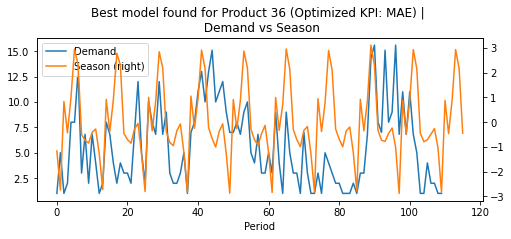

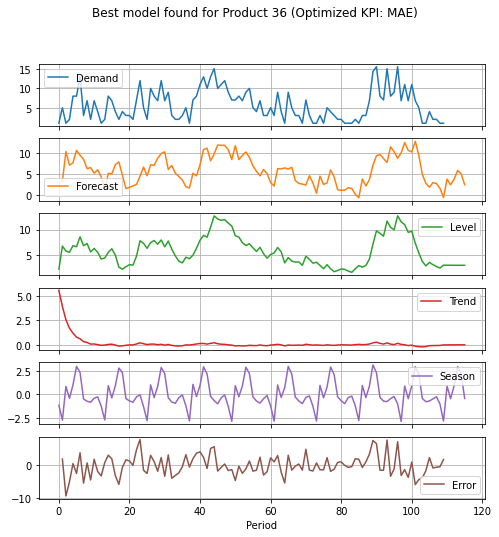

In [288]:
# Forecast
d = dataset['Demand'].tolist() # Convert dataframe column to a list
df = exp_smooth_opti_mae(d, extra_periods=6, slen=12)
df.index.name = 'Period'
display(df)

# KPI
print(f'Optimization KPI: MAE - Best Solution KPI (without Outliers) - {product}')
kpi(df)

# Plot
# Subplot per component
df[['Demand', 'Forecast']].plot(figsize=(8,3), title=f'Best model found for {product} (Optimized KPI: MAE)', style=['-','--'])
df[['Forecast', 'Level', 'Trend']].plot(figsize=(8,3), secondary_y=['Season'], title=f'Best model found for {product} (Optimized KPI: MAE) | \n Forecast vs Level vs Trend', style=['-','--',':'])
df[['Trend', 'Error']].plot(figsize=(8,3), title=f'Best model found for {product} (Optimized KPI: MAE) | \n Trend vs Error', style=['-','--'])
df[['Demand', 'Season']].plot(figsize=(8,3), secondary_y=['Season'], title=f'Best model found for {product} (Optimized KPI: MAE) | \n Demand vs Season')
df.plot(figsize=(8,8), title=f'Best model found for {product} (Optimized KPI: MAE)', subplots=True, grid=True)